# Final Project 4

For my project, I hope to predict the sale price of homes, using the features of each property.

The dataset is the Ames Housing dataset, available on Kaggle. The training set consists of 1460 observations, with 79 features.


## Hypothesis: The sale price of a home is positively correlated with (1) its size and (2) how recently it was built.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn import metrics

In [2]:
data = pd.read_csv("housepricestrain.csv")

### To get started, I've plotted each home's above-ground living area against its sale price.

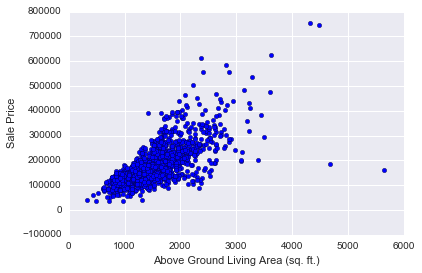

In [4]:
plt.scatter(x=data['GrLivArea'], y = data['SalePrice'])
plt.xlabel("Above Ground Living Area (sq. ft.)")
plt.ylabel("Sale Price")

As expected, the scatterplot shows an upward trend with sale prices increasing as the size of a home (measured in total square feet of above-ground living area) increases. This makes sense, as larger homes generally sell for more, on average, than smaller homes.

However, there are two notable outliers--both homes that have much more above-ground living area than the other homes in the dataset, but that also sold for less than $200K each. I will remove these outliers from the dataset.

In [5]:
# Remove outliers
data=data[data['GrLivArea'] < 4000]

## Exploratory Data Analysis

### Target (SalePrice)

The average sale price is 180K. However, as the histogram below shows, the distribution of sale prices is right-skewed, with a number of homes selling for considerably more than the median sale price of 163K.

In [6]:
data.SalePrice.describe()

count      1456.000000
mean     180151.233516
std       76696.592530
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      625000.000000
Name: SalePrice, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117e12208>]], dtype=object)

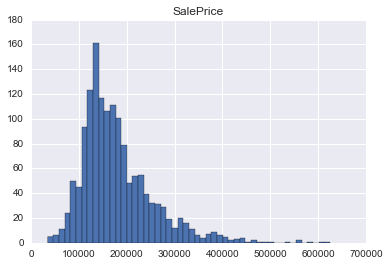

In [7]:
data.hist("SalePrice", bins = 50)

### Top 10 Features Correlated with SalePrice

There are 79 features in the dataset, covering nearly every aspect of he homes in the dataset. This EDA examines the 10 features most highly correlated with our target (SalePrice).

In [30]:
correlations = data.corr()
ordered_corr = correlations.loc["SalePrice"].sort_values(ascending = False)
top_10 = pd.DataFrame(ordered_corr[0:11])
top_10_cols = list(top_10.index)
data_top10 = data[top_10_cols]
print("Features Most Highly Correlated with Sale Price")
top_10 = top_10.rename(columns = {"SalePrice":"Correlation with SalePrice"})
top_10

Features Most Highly Correlated with Sale Price


,Correlation with SalePrice
SalePrice,1.000000
OverallQual,0.800858
GrLivArea,0.720516
GarageCars,0.649256
TotalBsmtSF,0.646584
GarageArea,0.636964
1stFlrSF,0.625235
FullBath,0.559048
TotRmsAbvGrd,0.537462
YearBuilt,0.535279


As illustrated by the heatmap below, a number of these top 10 features are collinear. However, I still believe these features to be a good starting point for understanding the data, as they illuminate the things that buyers most care about.

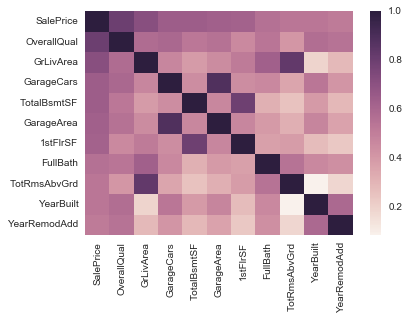

In [31]:
sns.heatmap(data_top10.corr())

#### 1. OverallQual

OverallQual is a categorical variable representing the rating of the overall material and finish of the house. Values range from 1 to 10, with 1 being "very poor" and 10 being "very excellent". 

OverallQual is the feature that most strongly correlates with SalePrice. The overall material and finish most homes in the training set are rated as average, falling in the middle of the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b5709e8>]], dtype=object)

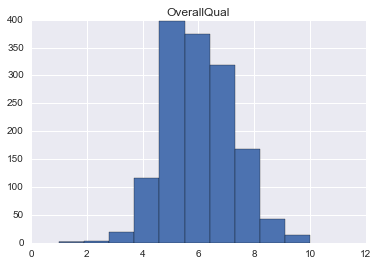

In [32]:
data.hist("OverallQual")

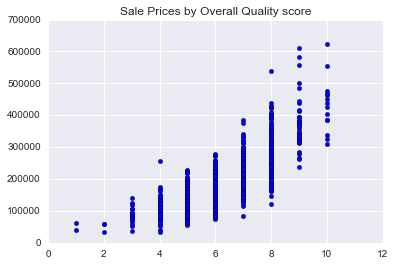

In [33]:
plt.scatter(data["OverallQual"], data["SalePrice"])
plt.title("Sale Prices by Overall Quality score");

Sale prices increase as the overall quality of a home increases. 

However, it is notable that each tier covers a significant range of sale prices. For example, the highest-quality homes (Tier 10) sold for between 300,000 to more than twice that at above 600,000.

#### 2. GrLivArea

GrLivArea is a numeric variable representing the above grade (ground) living area of a home in square feet. This variable correlates strongly with SalePrice, which is consistent with common sense--most people would expect a home with more living area to sell for more than a home with less living area, all else equal.

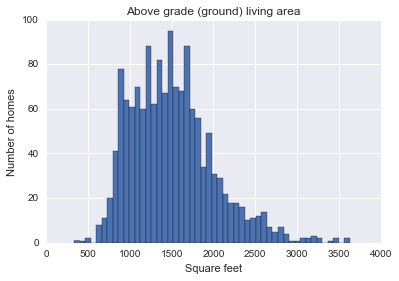

In [34]:
plt.hist(data["GrLivArea"], bins = 50)
plt.title("Above grade (ground) living area")
plt.xlabel("Square feet")
plt.ylabel("Number of homes");

#### 3 and 4. GarageCars and GarageArea

Two garage-related features correlate highly with SalePrice:

1. GarageCars -- the number of cars that can be stored in a home's garage
2. GarageArea -- the size of a home's garage, measured in square feet

Not surprisingly, these two variables are also highly correlated with each other, as a larger garage enables the owner to store more cars. See heatmap above.

Most homes in the dataset have a two-car garage, pretty typical of most American homes, I imagine.

In [36]:
print("Number of homes in dataset, by number of cars in garage")
data.GarageCars.value_counts()

Number of homes in dataset, by number of cars in garage


2    823
1    369
3    178
0     81
4      5
Name: GarageCars, dtype: int64

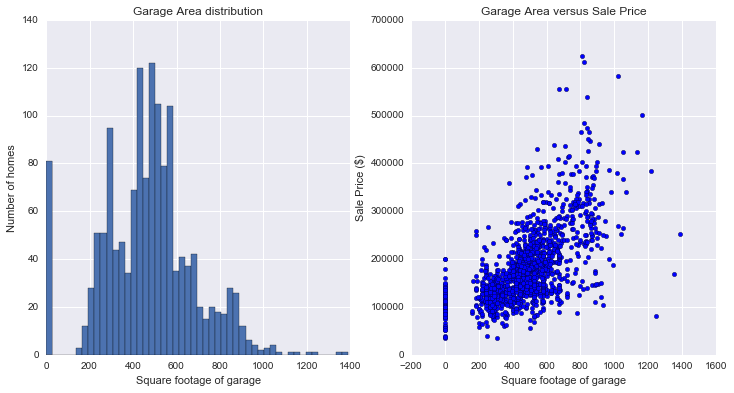

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data.GarageArea, bins =  50)
plt.ylabel("Number of homes")
plt.xlabel("Square footage of garage")
plt.title("Garage Area distribution")
plt.subplot(1,2,2)
plt.scatter(data.GarageArea, data.SalePrice)
plt.ylabel("Sale Price ($)")
plt.xlabel("Square footage of garage")
plt.title("Garage Area versus Sale Price");

#### 5 and 6. TotalBsmtSF and 1stFlrSF

TotalBsmtSF is a numeric variable measuring the total square feet of a home's basement area. 

1stFlrSF is a numeric variable measuring the first floor square feet of a home.

Besides being highly correlated with SalePrice, they are also highly correlated with each other.

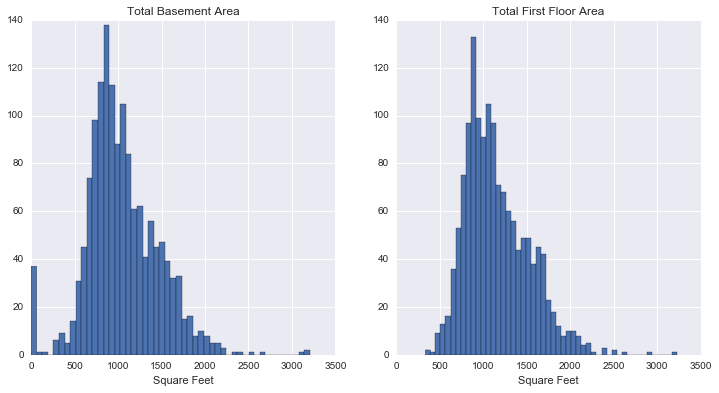

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data["TotalBsmtSF"],bins = 50)
plt.title("Total Basement Area")
plt.xlabel("Square Feet")
plt.subplot(1,2,2)
plt.hist(data["1stFlrSF"],bins = 50)
plt.title("Total First Floor Area")
plt.xlabel("Square Feet");

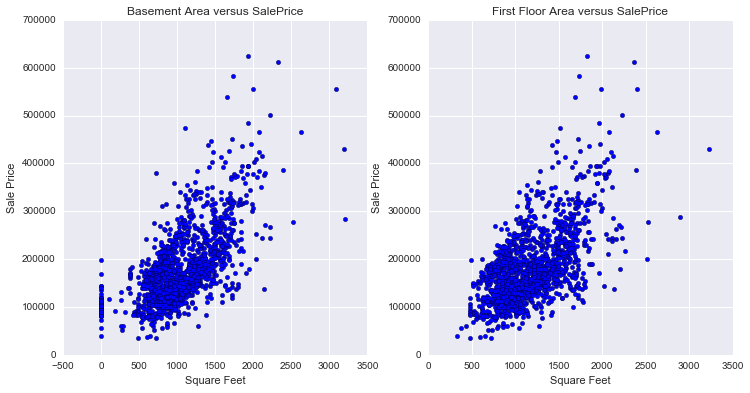

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(x = data["TotalBsmtSF"], y = data["SalePrice"])
plt.title("Basement Area versus SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Square Feet")
plt.subplot(1,2,2)
plt.scatter(x = data["1stFlrSF"], y = data["SalePrice"])
plt.title("First Floor Area versus SalePrice")
plt.ylabel("Sale Price")
plt.xlabel("Square Feet");

#### 7. FullBath
FullBath is a numeric variable measuring the number of full bathrooms above grade in a home. I am not surprised at all that this feature correlates highly with SalePrice.

In [46]:
print("Number of homes in dataset, by number of full bathrooms above grade")
data.FullBath.value_counts()

Number of homes in dataset, by number of full bathrooms above grade


2    767
1    650
3     30
0      9
Name: FullBath, dtype: int64

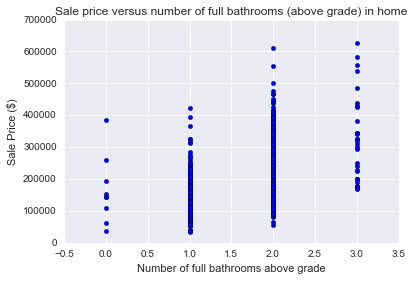

In [47]:
plt.scatter(data.FullBath, data.SalePrice)
plt.title("Sale price versus number of full bathrooms (above grade) in home")
plt.xlabel("Number of full bathrooms above grade")
plt.ylabel("Sale Price ($)");

#### 8. TotRmsAbvGrd

TotRmsAbvGrd is a numeric variable representing the total rooms (excluding bathrooms) in a home that are above grade.

As noted in the heatmap above, this feature also correlates highly with the amount of above-ground living area in a home. Both of these features represent the total size of a home, and their high correlation with sale price is evidence supporting the hypothesis--i.e, sale prices correlate positively with the size of a home.

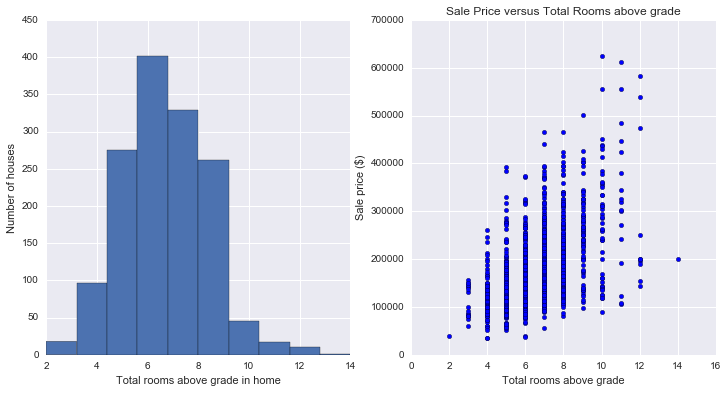

In [48]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(data.TotRmsAbvGrd)
plt.xlabel("Total rooms above grade in home")
plt.ylabel("Number of houses")
plt.subplot(1,2,2)
plt.scatter(data.TotRmsAbvGrd, data.SalePrice)
plt.title("Sale Price versus Total Rooms above grade")
plt.xlabel("Total rooms above grade")
plt.ylabel("Sale price ($)");

#### 9 and 10. YearBuilt and YearRemodAdd

YearBuilt represents the original construction date of the home. The largest category of homes are those built in 2000 or later, presumably reflecting the housing boom in those years. The scatterplot below provides evidence supporting the hypothesis that newer homes tend to sell for more, on average.

YearRemodAdd represents the remodel date of the home. However, this value is the same as the construction date if no remodeling or additions were made to the home. 

In [51]:
print("Year the oldest home in the dataset was built:", data.YearBuilt.min())
print("Year the newest home in the dataset was built:", data.YearBuilt.max())

Year the oldest home in the dataset was built: 1872
Year the newest home in the dataset was built: 2010


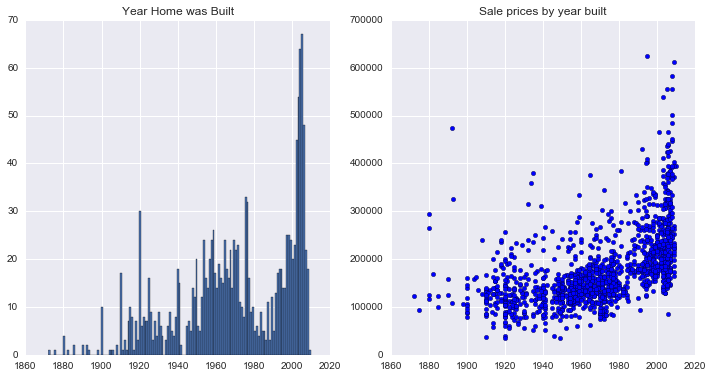

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data["YearBuilt"], bins= 139)
plt.title("Year Home was Built")
plt.subplot(1,2,2)
plt.scatter(data["YearBuilt"], data["SalePrice"])
plt.title("Sale prices by year built");

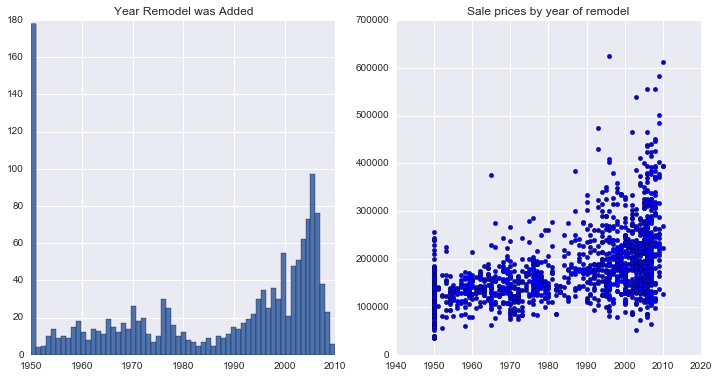

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data["YearRemodAdd"], bins= 61)
plt.title("Year Remodel was Added")
plt.subplot(1,2,2)
plt.scatter(data["YearRemodAdd"], data["SalePrice"])
plt.title("Sale prices by year of remodel");

## Missing Values

There are a number of columns with missing values.

1. First, several hundred rows are missing values LotFrontage, a numeric feature measuring the number of feet of the property that faces the street. I replaced these missing values with the median value for LotFrontage in the dataset.

2. Most of the columns with missing values are categorical features, where the missing value indicates that the property doesn't have the relevant feature. For example, a missing value for GarageType really means that the home didn't have a garage. For these columns, I replaced the missing values with a string, of the form "No[feature]".

3. Some rows have missing values for MasVnrArea, which means that the home didn't have any areas of masonry veneer. I replaced these missing values with "1". As discussed below, the distribution of MasVnrArea is skewed, and the "1" for these rows will be log-transformed into "0".

4. Only one row was missing a value for Electrical, which is a categorical variable that represents the type of electrical system used in a home. Most homes in the training set (1330 out of 1456) use standard circuit breakers and Romex. So I replaced the missing value here with the mode.

In [55]:
# get columns with missing values
missing_values = []
for col in data.columns:
    if data[col].isnull().sum()>0:
        missing_values.append(col)
missing_values

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [56]:
# LotFrontage
# How many missing values are there?
data.LotFrontage.isnull().sum()

259

In [57]:
# Replace missing values with median
lf_median = data.LotFrontage.median()
data.LotFrontage = data.LotFrontage.fillna(lf_median, axis = 0)

In [58]:
# The missing values for these features are all None or a similar value
# Missing numeric values are ultimately replaced with 1 for log transformation later
data.Alley = data.Alley.fillna("NoAlleyAccess", axis = 0)
data.MasVnrType = data.MasVnrType.fillna("None",axis = 0)
data.MasVnrArea = data.MasVnrArea.fillna(1, axis = 0)
data.MasVnrArea.replace(to_replace = 0, value = 1,inplace = True)
data.BsmtQual = data.BsmtQual.fillna("NoBasement",axis = 0)
data.BsmtCond = data.BsmtCond.fillna("NoBasement",axis = 0)
data.BsmtExposure = data.BsmtExposure.fillna("NoBasement",axis = 0)
data.BsmtFinType1 = data.BsmtFinType1.fillna("NoBasement",axis = 0)
data.BsmtFinType2 = data.BsmtFinType2.fillna("NoBasement",axis = 0)
data.FireplaceQu = data.FireplaceQu.fillna("NoFireplace", axis = 0)
data.GarageType = data.GarageType.fillna("NoGarage", axis = 0)
data.GarageYrBlt = data.GarageYrBlt.fillna(0, axis = 0)
data.GarageFinish = data.GarageFinish.fillna("NoGarage", axis = 0)
data.GarageQual = data.GarageQual.fillna("NoGarage",axis = 0)
data.GarageCond = data.GarageCond.fillna("NoGarage",axis = 0)
data.PoolQC = data.PoolQC.fillna("NoPool",axis = 0)
data.Fence = data.Fence.fillna("NoFence",axis = 0)
data.MiscFeature = data.MiscFeature.fillna("NoMiscFeature",axis = 0)

In [59]:
def replace_with_mode(feature):
    mode = data[feature].value_counts().index[0]
    data[feature] = data[feature].fillna(mode, axis = 0)
    
replace_with_mode("Electrical")

## Skewed Variables: Box-Cox Transformation

The distributions of a number of numeric features were significantly skewed (i.e., skew > 0.5). This is a problem because many machine learning models assume that feature values are distributed normally.

I used the Box-Cox transormation to normalize features whose skew exceeded 0.5. 

In [60]:
numeric_columns = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd",\
                  "LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
print("Skew of Features in Dataset")
print()
for c in numeric_columns:
    print(c, stats.skew(data[c].dropna()))

Skew of Features in Dataset

GrLivArea 0.8343317105860125
GarageArea 0.13285411234363464
TotalBsmtSF 0.48589409938174744
1stFlrSF 0.8661873255069391
TotRmsAbvGrd 0.6607348672523655
LotFrontage 1.7096933971076271
LotArea 12.574589805730213
MasVnrArea 2.663386522915679
BsmtFinSF1 0.7440879010708922
BsmtFinSF2 4.244208669084649
BsmtUnfSF 0.920808873459641
2ndFlrSF 0.7770647552870847
LowQualFinSF 8.98929107000648
WoodDeckSF 1.5496720022224146
OpenPorchSF 2.3374349270732453


In [61]:
cols_with_zeros = ["BsmtFinSF1","BsmtFinSF2",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
for c in cols_with_zeros:
    data[c].replace(to_replace = 0, value = 1, inplace = True)

In [62]:
for c in numeric_columns:
    col_name = "bc_" + c
    if stats.skew(data[c].dropna()) > .5:
        try:
            data[col_name] = stats.boxcox(data[c])[0]
        except:
            try:
                for i in range(len(data)):
                    if data.iloc[i][c] <= 0:
                        data.iloc[i][c] = 1
                data[col_name] = stats.boxcox(data[c])[0]
            except:
                pass

Examples of using Box-Cox transformation on GrLivArea (above ground living area) and 1stFlrArea (the square footage of a home's first floor) can be seen in the histograms below.

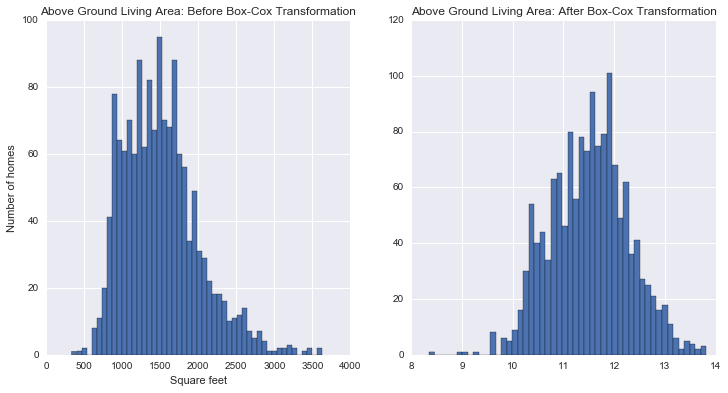

In [63]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(data.GrLivArea, bins = 50)
plt.title("Above Ground Living Area: Before Box-Cox Transformation")
plt.ylabel("Number of homes")
plt.xlabel("Square feet")
plt.subplot(1,2,2)
plt.hist(data.bc_GrLivArea, bins= 50)
plt.title("Above Ground Living Area: After Box-Cox Transformation")

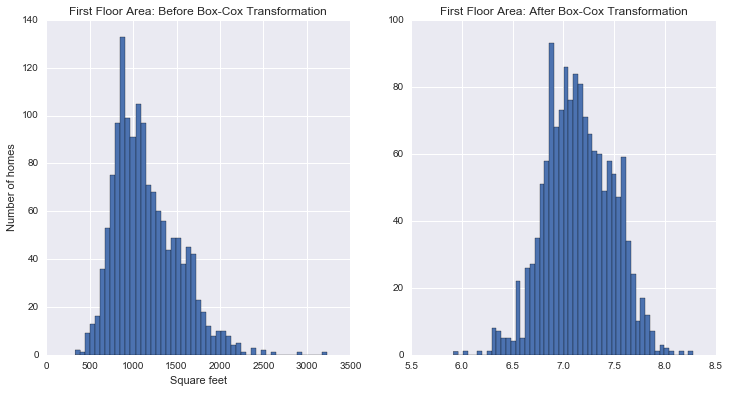

In [64]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(data["1stFlrSF"], bins = 50)
plt.title("First Floor Area: Before Box-Cox Transformation")
plt.ylabel("Number of homes")
plt.xlabel("Square feet")
plt.subplot(1,2,2)
plt.hist(data.bc_1stFlrSF, bins = 50)
plt.title("First Floor Area: After Box-Cox Transformation")

In [65]:
columns_to_drop = []
numeric_columns = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "TotRmsAbvGrd",\
                  "LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2",\
                  "BsmtUnfSF","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF"]
for c in numeric_columns:
    if stats.skew(data[c]) > .5:
        columns_to_drop.append(c)
        
for c in columns_to_drop:
    data = data.drop(c, axis = 1)
    
#data.columns

## Create Dummy Variables

The dataset includes many categorical features. I used one-hot encoding to convert these values into dummy variables.

Furthermore, I also dropped the column for "Id", which merely identified each house in the dataset.

In [66]:
feature_list = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',\
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',\
               'OverallQual','OverallCond','RoofStyle','RoofMatl',\
               'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',\
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',\
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',\
               'FireplaceQu','GarageType','GarageFinish','GarageQual',\
               'GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','YrSold',\
               'SaleType','SaleCondition']
for feature in feature_list:
    dummy = pd.get_dummies(data[feature], prefix = feature, drop_first = True)
    data = data.join(dummy)

In [67]:
df = data.copy()

In [68]:
for feature in feature_list:
    df = df.drop(feature, axis = 1)

In [69]:
df = df.drop("Id",axis = 1)
df.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,2003,2003,856,1,0,2,1,3,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1976,1976,1262,0,1,2,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2001,2002,920,1,0,2,1,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1915,1970,756,1,0,1,0,3,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2000,2000,1145,1,0,2,1,4,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Validation and Prediction Metric

I chose to use K-Fold cross-validation because the number of observations in the dataset (1460 before outliers are removed) is fairly small. I expect that K-Fold cross-validation will prove more effective than a training/test set split, as each partition will be treated as a test set in turn.

I chose to use Root Mean Squared Error (RMSE) as a prediction metric because it is appropriate for the question (i.e., how close is our estimate to the actual sale price) and because it is easily interpreted (i.e., our model is off by X amount of dollars on average). Well, technically, it is the average RMSE, as each model is evaluated using K-Fold cross-validation, but the basic idea is that RMSE is appropriate to the problem and easily interpreted.

### 1. Define X and y

In [70]:
y = df.SalePrice
X = df.drop("SalePrice", axis = 1)

### 2. Cross Validation

In [71]:
cv = KFold(n_splits=5, shuffle=True, random_state=7)

### 3. Establish Baseline for Assessing Models

In [72]:
mean_SalePrice = df.SalePrice.mean()
squared_errors = 0
for sp in df.SalePrice:
    squared_errors += (mean_SalePrice-sp)**2
print("RMSE, if mean sale price is always predicted:",np.sqrt(squared_errors/len(df)))

RMSE, if mean sale price is always predicted: 76670.2498906


### As a baseline for evaluating the models below, I calculated the root mean squared error (RMSE) if the mean sale price was always predicted. This value, which turns out to be ~ 76,000, is what each model below, at a minimum, must beat.

## 1. Linear Regression 

In [74]:
lr_model = LinearRegression()
lr_model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
score = np.sqrt(-cross_val_score(lr_model, X, y, scoring='neg_mean_squared_error', cv=cv))
print("RMSEs:",score)
print("Avg RMSE:",np.mean(score))

RMSEs: [ 27157.09173154  29170.23887257  47325.12747467  22909.56755787
  26320.0171066 ]
Avg RMSE: 30576.4085486


In [76]:
list(zip(X.columns,lr_model.coef_))

[('YearBuilt', 253.9533982945068),
 ('YearRemodAdd', 86.876021676336478),
 ('TotalBsmtSF', 40.884229586578925),
 ('BsmtFullBath', 2349.1186602457847),
 ('BsmtHalfBath', -997.55186973026775),
 ('FullBath', 7214.8104236148474),
 ('HalfBath', 3662.6747762928899),
 ('BedroomAbvGr', -2305.9499169329329),
 ('KitchenAbvGr', -12952.062198549662),
 ('Fireplaces', 6262.7165642174978),
 ('GarageYrBlt', -77.525051435538444),
 ('GarageCars', 3916.4855306439367),
 ('GarageArea', 21.947726740434518),
 ('EnclosedPorch', 12.711549663644291),
 ('3SsnPorch', 39.752175541284259),
 ('ScreenPorch', 38.035762783905739),
 ('PoolArea', 561.03413531187653),
 ('MiscVal', -1.78537972385584),
 ('bc_GrLivArea', 26158.615243061489),
 ('bc_1stFlrSF', -1228.2252128879245),
 ('bc_TotRmsAbvGrd', 7629.8513736254672),
 ('bc_LotFrontage', 707.16706210423649),
 ('bc_LotArea', 4.1074599721468985e-08),
 ('bc_MasVnrArea', -1558.133216812626),
 ('bc_BsmtFinSF1', 534.90778520686081),
 ('bc_BsmtFinSF2', -2052983.0882966132),
 ('b

#### Linear Regression, using all features, has an average RMSE of a bit over 30K. That is better than the baseline (76K), but let's see if we can do better.

## 2. Lasso

Lasso seems like a good choice, especially given the large number of features in the dataset. Lasso will force some coefficients to zero, enabling us to identify the most important features.

In [77]:
lasso1 = Lasso(normalize = True)
lasso1_parameters = {'alpha': [.1, 1, 10, 12, 12.20, 12.211, 12.212, 12.2125, 15, 50]}
lasso1_grid = GridSearchCV(lasso1, lasso1_parameters, cv=cv)
lasso1_grid.fit(X,y)
lasso1_grid.best_params_

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

{'alpha': 12.211}

In [78]:
lasso1b = Lasso(normalize = True, alpha = 12.211)
lasso1b.fit(X,y)

Lasso(alpha=12.211, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
score =np.sqrt(-cross_val_score(lasso1b, X, y, scoring = "neg_mean_squared_error",cv=cv))
print('RMSEs:',score)
print("Avg RMSE:",np.mean(score))

RMSEs: [ 24780.06496047  21280.02300589  27345.45791567  21801.81816231
  24733.18285048]
Avg RMSE: 23988.109379


### Lasso is a significant improvement over my linear regression model, as the average RMSE has fallen to just under 24K. Let's see how many features were kept by Lasso.

In [83]:
lasso1bFeatures = list(zip(X.columns,lasso1b.coef_))
lasso1bCols = [f for f,c in lasso1bFeatures if c != 0]
print("Lasso kept",len(lasso1bCols),"out of",len(X.columns),"features.")

Lasso kept 139 out of 299 features.


### So Lasso has identified 139 out of 299 features as the most important. Let's see if using these 139 features results in a better linear regression model.

In [84]:
X1b = df[lasso1bCols]
lr_lasso1b = LinearRegression()
lr_lasso1b.fit(X1b,y)
score = np.sqrt(-cross_val_score(lr_lasso1b, X1b, y, scoring = "neg_mean_squared_error",cv=cv))
print('RMSEs:',score)
print('Avg RMSE:',np.mean(score))

RMSEs: [ 24483.47143364  20604.38022592  25655.46683671  21593.26559204
  23832.39210905]
Avg RMSE: 23233.7952395


### Indeed, a combination of Lasso and linear regression appears to work well. By using Lasso to identify features to keep and then building a linear regression model using only those features, we have driven our average RMSE to the lowest point yet--just above 23K.

## 3. Ridge

### As shown above, regularization has improved performance, allowing us to drive down our average RMSE. Let's see if Ridge regularization works better than Lasso.

In [85]:
ridge = Ridge(normalize = True)

In [86]:
ridge_parameters = {'alpha': [.05, .1, .12, .125, .13,.2, .25, .5, .75, 1, 5, 10, 25, 50, 75]}
ridge_grid = GridSearchCV(ridge, ridge_parameters, cv=cv)
ridge_grid.fit(X,y)
ridge_grid.best_params_

{'alpha': 0.125}

In [87]:
ridge2 = Ridge(alpha = 0.125, normalize = True)
ridge2.fit(X,y)

Ridge(alpha=0.125, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [88]:
score = np.sqrt(-cross_val_score(ridge2, X, y, scoring='neg_mean_squared_error', cv=cv))
print("RMSEs:",score)
print('Avg RMSE:', np.mean(score))

RMSEs: [ 24456.18208329  22150.4539062   27895.79831424  22876.08505849
  25435.64640949]
Avg RMSE: 24562.8331543


In [89]:
list(zip(X.columns,ridge2.coef_))

[('YearBuilt', 112.44948658796635),
 ('YearRemodAdd', 123.73899375486144),
 ('TotalBsmtSF', 24.58513961945464),
 ('BsmtFullBath', 3739.2804162479929),
 ('BsmtHalfBath', -1430.4338069637986),
 ('FullBath', 8613.0555483520438),
 ('HalfBath', 5734.7662886918979),
 ('BedroomAbvGr', -1297.6224115017515),
 ('KitchenAbvGr', -12545.664842059787),
 ('Fireplaces', 5470.3308951009703),
 ('GarageYrBlt', -0.14046477155442968),
 ('GarageCars', 4297.7411855659793),
 ('GarageArea', 20.575207695834635),
 ('EnclosedPorch', 8.6769400158105903),
 ('3SsnPorch', 34.512467367255489),
 ('ScreenPorch', 41.7010081885212),
 ('PoolArea', 23.924962122108472),
 ('MiscVal', 0.62533172280611737),
 ('bc_GrLivArea', 12683.158826501893),
 ('bc_1stFlrSF', 19704.528016241493),
 ('bc_TotRmsAbvGrd', 10504.370777131513),
 ('bc_LotFrontage', 794.50794022778223),
 ('bc_LotArea', 0.0),
 ('bc_MasVnrArea', 478.00527387449102),
 ('bc_BsmtFinSF1', 550.99864291324013),
 ('bc_BsmtFinSF2', 1648.5908089549162),
 ('bc_BsmtUnfSF', -111.9

### Ridge appears to offer respectable performance, with an average RMSE of ~24K. However, it is higher than the average RMSE we achieved with Lasso and Linear Regression, using Lasso-identified features.

## 4. Random Forest

### Finally, let's see if Random Forest results in a lower RMSE.

In [90]:
rf = RandomForestRegressor(n_jobs = 2)
rf_parameters = {"n_estimators":range(100, 550, 50), "max_depth":range(1,15)}
rf_grid = GridSearchCV(rf, rf_parameters, cv=cv)
rf_grid.fit(X,y)
rf_grid.best_params_

{'max_depth': 13, 'n_estimators': 150}

In [91]:
rf2 = RandomForestRegressor(n_jobs = 2, n_estimators = 150, max_depth = 13)
rf2.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [92]:
score =(np.sqrt(-cross_val_score(rf2, X, y, scoring='neg_mean_squared_error', cv=cv)))
print("RMSEs:",score)
print("Avg RMSE:", np.mean(score))

RMSEs: [ 27516.95089199  26539.8146542   31613.0036503   23986.33919472
  28450.90072343]
Avg RMSE: 27621.4018229


### Random Forest results in a slightly higher average RMSE than Lasso, Linear Regresssion plus Lasso, or Ridge. However, let's take a look at the feature importances.

In [96]:
fi = list(zip(X.columns,rf2.feature_importances_))
sig_features = []
total = 0
for col, imp in fi:
    if imp > .01:
        sig_features.append((col, imp))
        total += imp

print("Most important {} features in Random Forest model".format(len(sig_features)))
print()
for f,i in sig_features:
    print(f,i)
print()
print("Total explained by most important features:", total)

Most important 10 features in Random Forest model

YearBuilt 0.0552098395564
YearRemodAdd 0.0128652246486
TotalBsmtSF 0.0494357067905
GarageCars 0.245881113912
GarageArea 0.0243318690715
bc_GrLivArea 0.235152356715
bc_1stFlrSF 0.0456903763674
bc_TotRmsAbvGrd 0.0104799093298
bc_BsmtFinSF1 0.0342263913089
ExterQual_TA 0.127486200342

Total explained by most important features: 0.840758988042


### Although Random Forest resulted in a slightly higher average RMSE, it also provides the most interpretable model. The top 10 features in the Random Forest model explain 84% of our target, SalePrice.

### Furthermore, the top 10 Random Forest features provide evidence supporting our hypothesis--sale prices correlate positively with a home's size and how recently it was built.

7 out of the top 10 Random Forest features measure some aspect of a home's size (above-ground living area; the square footage of a home's garage and the number of cars it can accommodate; the total square footage of a home's basement and the total amount of the basement's finished square footage; the square footage of a home's first floor; and the total number of rooms above grade).

Another 2 of the top 10 Random Forest features related to the home's age (Year the home was built, adn the year any remodel was added).

To a large extent, the top 10 Random Forest features overlap with the top 10 features examined in the Exploratory Data Analysis above.

Random Forest also identifies ExterQualTA, a categorical variable representing the quality rating of the house's exterior materials, as a significant feature. This should be explored further. 

## Visualization of Relationship between SalePrice and Two Strongest Independent Variables

Random Forest identified GarageCars and total above-ground living area as the two most significant independent variables. Let's visualize the relationships between these variables and the dependent variable (SalePrice).

#### GarageCars and SalePrice

In [98]:
print("Mean Sale Price, by capacity of garage")
data.groupby("GarageCars")["SalePrice"].mean()

Mean Sale Price, by capacity of garage


GarageCars
0    103317
1    128116
2    183880
3    305389
4    192655
Name: SalePrice, dtype: int64

In [99]:
print("Standard Deviations of Mean Sale Price, by capacity of garage")
data.groupby("GarageCars")["SalePrice"].std()

Standard Deviations of Mean Sale Price, by capacity of garage


GarageCars
0    32815.023389
1    30412.386884
2    51641.823380
3    96483.146445
4    52621.839744
Name: SalePrice, dtype: float64

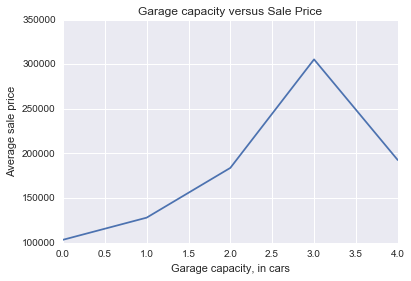

In [102]:
msp = [103317, 128116, 183880, 305389, 192655]
plt.plot(msp)
plt.xlabel("Garage capacity, in cars")
plt.ylabel("Average sale price")
plt.title("Garage capacity versus Sale Price")

### Above-Ground Living Area and SalePrice

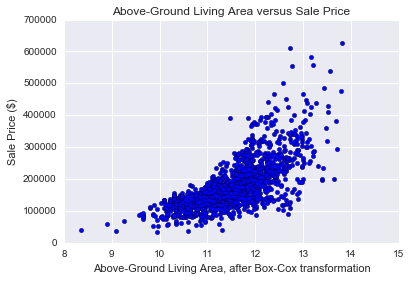

In [105]:
plt.scatter(x=data.bc_GrLivArea,y=data.SalePrice)
plt.title("Above-Ground Living Area versus Sale Price")
plt.xlabel("Above-Ground Living Area, after Box-Cox transformation")
plt.ylabel("Sale Price ($)");

## Conclusion and Next Steps

In terms of minimizing average RMSE, a two-step strategy of using Lasso to identify important features and then building a linear regression model using those features worked best. However, that model included over 100 features.

Random Forest had a higher average RMSE, although it was still comparable to results achieved with linear regression, Lasso, and Ridge. Moreover, Random Forest provided a significantly shorter list of significant features, and therefore, a much more interpretable model. For a non-technical audience, I would definitely use Random Forest and its 10 most significant features.

The analysis also indicated further areas to explore. As noted above, Random Forest identified the quality of the materials used in a home's exterior as a significant feature. I was struck by how much the model relied on measures of a home's size and age, rather than indications of the quality of a home. I find it difficult to believe that homebuyers are indifferent to the quality of a home, although qualilty may be difficult for assess and value for homebuyers who are not necessarily knowledgeable about house construction. Exploring the impact of home quality would be an interesting area of further research.

I also find it curious that a home's neighborhood apparently did not significantly impact its price, at least as far as the models discussed above. As the cliche goes, the most important element of a property is "location, location, location". Exploring this would also be an interesting and fruitful area of further research.